# Yöntem 2: Saatlik Tahmin Modelinin Test Edilmesi ve Yorumlanması

Bu notebook, bir önceki `model_training` adımında hiperparametre optimizasyonu ile elde edilen en iyi saatlik tahmin modelinin (`best_tuned_hourly_model.keras`) nihai performansını değerlendirmeyi ve modelin karar mekanizmasını anlamayı hedefler.

Süreç aşağıdaki adımlardan oluşacaktır:
1.  Gerekli kütüphanelerin (özellikle `SHAP`) yüklenmesi ve ortamın hazırlanması.
2.  Eğitilmiş en iyi modelin, ölçekleyicilerin ve test verilerinin yüklenmesi.
3.  Modelin test seti üzerindeki standart performans metriklerinin (MAE, RMSE, R²) hesaplanması ve görselleştirilmesi.
4.  Modelin hangi durumlarda daha çok hata yaptığını anlamak için zamana (saat, gün) dayalı detaylı hata analizi yapılması.
5.  Modelin yorumlanabilirliğini artırmak ve en etkili öznitelikleri belirlemek için **SHAP (SHapley Additive exPlanations)** analizi uygulanması.

### 1. Kütüphanelerin Yüklenmesi ve Ortam Hazırlığı

Gerekli kütüphaneleri ve dosya yollarını tanımlayarak analiz ortamımızı hazırlıyoruz. `SHAP` kütüphanesi, modelimizin tahminlerini hangi özniteliklerin ne yönde ve ne kadar etkilediğini anlamamızı sağlayacak temel araçtır.

In [ ]:
import numpy as np
import pandas as pd
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import shap

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (18, 7)

DATA_PATH = '../../data/processed/'
MODEL_PATH = '../../models/'
FEATURE_META_PATH = '../../data/processed/feature_metadata_2_cleaned.csv'

### 2. Model ve Verilerin Yüklenmesi

Analize başlamadan önce, önceki adımlarda oluşturulan ve kaydedilen varlıkları yüklüyoruz:

- **`best_tuned_hourly_model.keras`**: Hiperparametre optimizasyonu sonucunda elde edilen en iyi model.
- **`scaler_1h.joblib` ve `scaler_target_1h.joblib`**: Sırasıyla öznitelikleri ve hedef değişkeni ölçeklendirmek için kullanılan `MinMaxScaler` nesneleri.
- **`hourly_model_data.npz`**: Eğitim (`X_train`) ve test (`X_test`, `y_test`) verilerini içeren dosya. `X_train` verisi, SHAP analizi için bir referans (background) veri seti olarak kullanılacaktır.

In [ ]:
best_model_path = os.path.join(MODEL_PATH, 'best_tuned_hourly_model.keras')


best_model = load_model(best_model_path, custom_objects={'Attention': tf.keras.layers.Attention})
print("En iyi ayarlanmış model başarıyla yüklendi.")

# 2. Scaler'ları yükle
scaler_features = joblib.load(os.path.join(DATA_PATH, 'scaler_1h.joblib'))
scaler_target = joblib.load(os.path.join(MODEL_PATH, 'scaler_target_1h.joblib'))
print("Özellik ve hedef scaler'ları yüklendi.")

processed_data = np.load(os.path.join(DATA_PATH, 'hourly_model_data.npz'))
X_train= processed_data['X_train'] 
X_test= processed_data['X_test']
y_test= processed_data['y_test']

# Hedef değişkeni de ölçeklendiriyoruz(inverse_transform için gerekli)
y_test_scaled = scaler_target.transform(y_test.reshape(-1, 1))

print("\nVeri Seti Boyutları:")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

c:\Users\90537\anaconda3\envs\tf-env\lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 20 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


En iyi ayarlanmış model başarıyla yüklendi.
Özellik ve hedef scaler'ları yüklendi.

Veri Seti Boyutları:
X_test: (5172, 24, 111), y_test: (5172,)


### 3. Test Seti Üzerinde Performans Değerlendirmesi

Modelin genelleme yeteneğini ölçmek için, daha önce hiç görmediği test verisi üzerinde tahminler yapılır. Elde edilen tahminler, `scaler_target` kullanılarak orijinal Euro birimine geri çevrilir ve gerçek değerlerle karşılaştırılarak performans metrikleri hesaplanır.

- **Performans Metrikleri**: Ortalama Mutlak Hata (MAE), Kök Ortalama Kare Hata (RMSE) ve R-Kare (R²) skorları, modelin genel doğruluğunu ve verideki varyansı ne kadar açıklayabildiğini gösterir.
- **Görselleştirmeler**:
    - **Zaman Serisi Grafiği**: Son bir haftalık periyotta modelin gerçek fiyat hareketlerini ne kadar yakından takip ettiğini gösterir.
    - **Dağılım Grafiği (Scatter Plot)**: Tahmin edilen ve gerçek değerler arasındaki genel ilişkiyi gösterir. Noktaların ideal çizgiye (y=x) yakınlığı, modelin tutarlılığını ifade eder.

162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
--------------------------------------------------
En İyi Model - Test Seti Performansı (Orijinal Ölçek)
Ortalama Mutlak Hata (MAE): 2.60 Euro
Kök Ortalama Kare Hata (RMSE): 3.21 Euro
R-Kare (R²) Skoru: 0.839
--------------------------------------------------


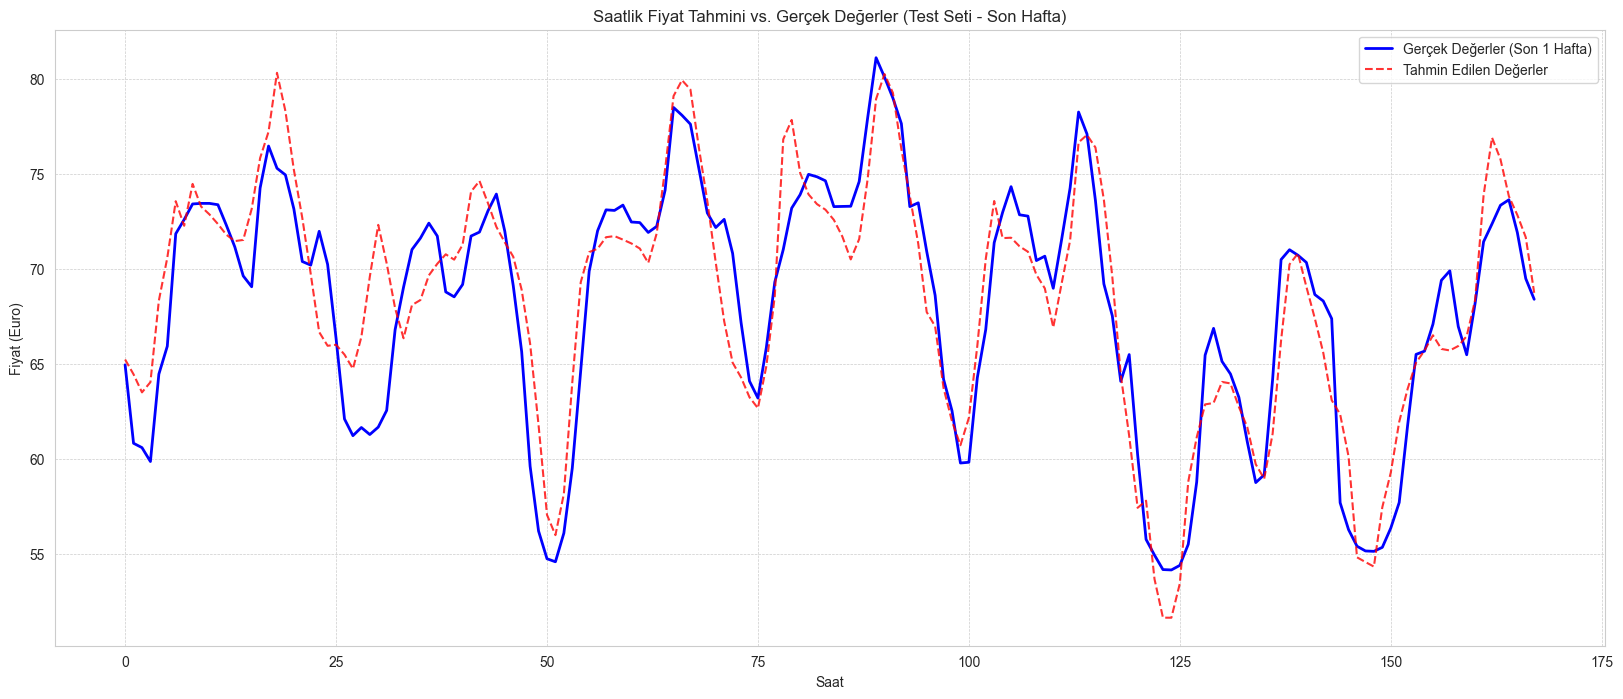

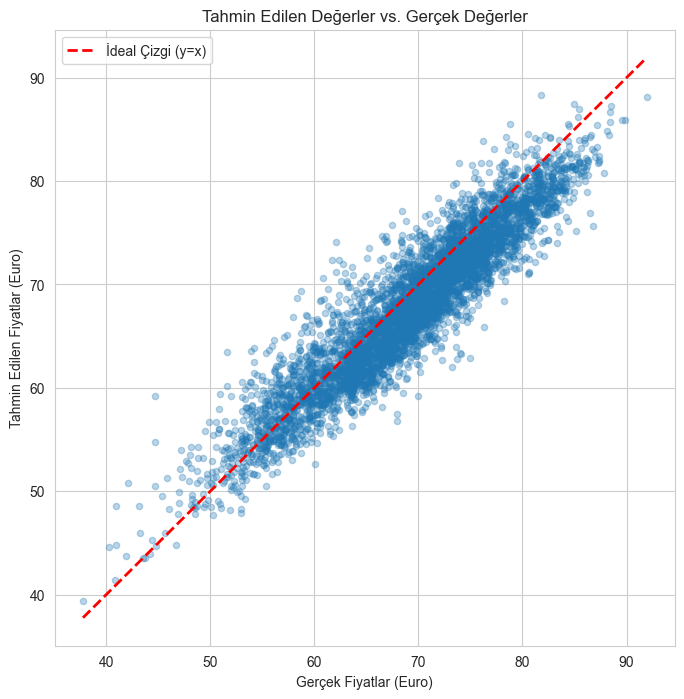

In [ ]:
y_pred_scaled = best_model.predict(X_test)

y_pred_original = scaler_target.inverse_transform(y_pred_scaled)

mae = mean_absolute_error(y_test, y_pred_original)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_original))
r2 = r2_score(y_test, y_pred_original)

print("-" * 50)
print("En İyi Model - Test Seti Performansı (Orijinal Ölçek)")
print(f"Ortalama Mutlak Hata (MAE): {mae:.2f} Euro")
print(f"Kök Ortalama Kare Hata (RMSE): {rmse:.2f} Euro")
print(f"R-Kare (R²) Skoru: {r2:.3f}")
print("-" * 50)


# Gerçek ve Tahmin Edilen Değerler Grafiği (Son 1 Hafta)
plt.figure(figsize=(20, 8))
plt.plot(y_test[-168:], label='Gerçek Değerler (Son 1 Hafta)', color='blue', linewidth=2)
plt.plot(y_pred_original[-168:], label='Tahmin Edilen Değerler', color='red', linestyle='--', alpha=0.8)
plt.title('Saatlik Fiyat Tahmini vs. Gerçek Değerler (Test Seti - Son Hafta)')
plt.xlabel('Saat')
plt.ylabel('Fiyat (Euro)')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# Scatter Plot (Tahmin vs Gerçek)
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_original, alpha=0.3, s=20)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='İdeal Çizgi (y=x)')
plt.title('Tahmin Edilen Değerler vs. Gerçek Değerler')
plt.xlabel('Gerçek Fiyatlar (Euro)')
plt.ylabel('Tahmin Edilen Fiyatlar (Euro)')
plt.legend()
plt.grid(True)
plt.show()

### 4. Detaylı Hata Analizi

Genel metriklerin ötesine geçerek, modelin sistematik olarak hata yapıp yapmadığını anlamak için hataları zamansal faktörlere göre inceliyoruz. Bu analiz, modelin zayıf yönlerini ortaya çıkarmak için önemlidir.

- **Hata Veri Çerçevesi**: Tahminler, gerçek değerler ve aralarındaki farkı içeren bir `DataFrame` oluşturulur.
- **Zamana Göre Analiz**: Orijinal zaman damgaları kullanılarak hatalar **günün saatine** ve **haftanın gününe** göre gruplandırılır. Box plot grafikleri, belirli zaman dilimlerinde hata varyansının artıp artmadığını (örneğin, fiyatların en oynak olduğu saatlerde) net bir şekilde gösterir.

Hata analizi için DataFrame başarıyla oluşturuldu.


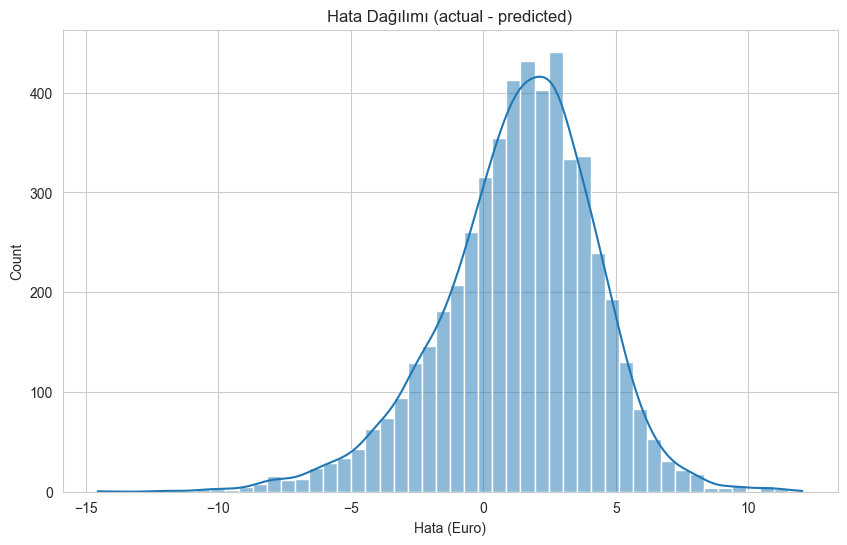

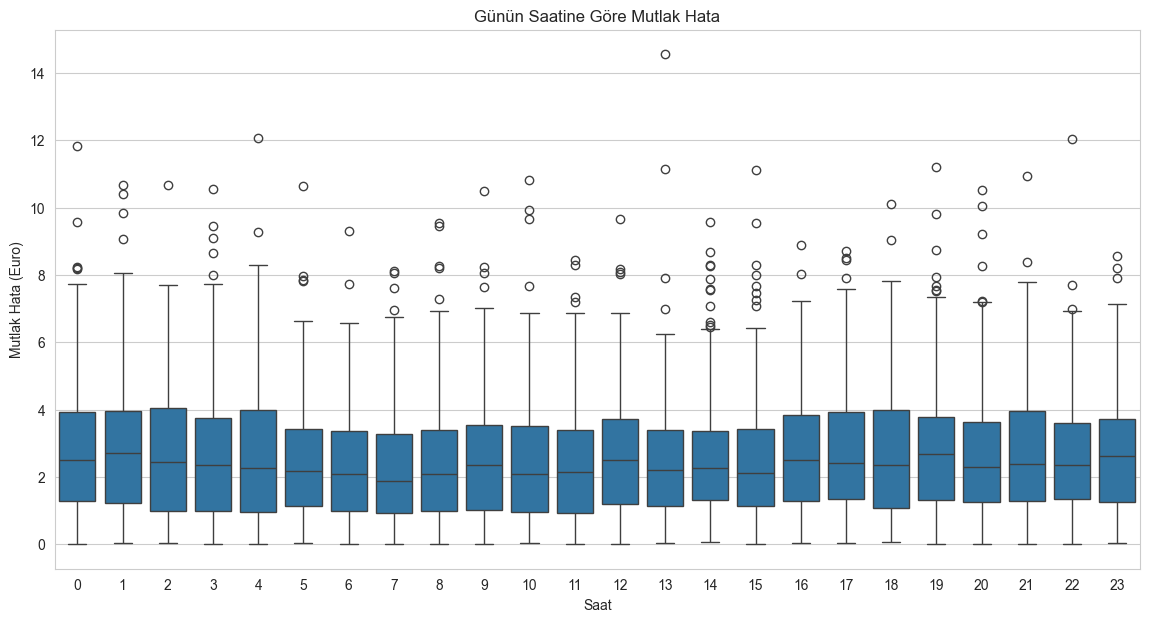

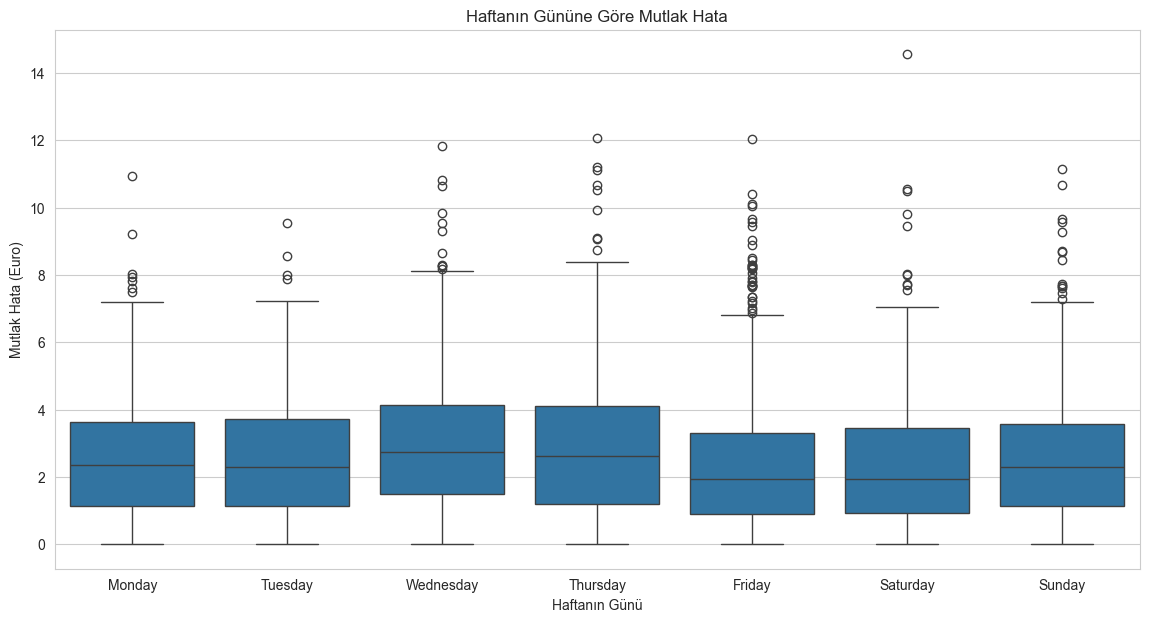

In [ ]:

try:
    energy_df_full = pd.read_csv('../../data/raw/energy_dataset.csv')
    
    energy_df_full['time'] = pd.to_datetime(energy_df_full['time'], utc=True)
    

    original_energy_df = pd.read_csv('../../data/raw/energy_dataset.csv')
    original_energy_df['time'] = pd.to_datetime(original_energy_df['time'], utc=True)

    
    test_size = len(y_test)
    test_timestamps = original_energy_df['time'].iloc[-test_size:]

    error_df = pd.DataFrame({
        'timestamp': test_timestamps.values,  
        'actual': y_test.flatten(),
        'predicted': y_pred_original.flatten()
    })
    
    error_df['error'] = error_df['actual'] - error_df['predicted']
    error_df['absolute_error'] = np.abs(error_df['error'])

    error_df['hour'] = error_df['timestamp'].dt.hour
    error_df['weekday'] = error_df['timestamp'].dt.day_name()

    print("Hata analizi için DataFrame başarıyla oluşturuldu.")

    # Hata Dağılımı Grafiği
    plt.figure(figsize=(10, 6))
    sns.histplot(error_df['error'], bins=50, kde=True)
    plt.title('Hata Dağılımı (actual - predicted)')
    plt.xlabel('Hata (Euro)')
    plt.show()

    # Saate Göre Hata Analizi
    plt.figure(figsize=(14, 7))
    weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    sns.boxplot(x='hour', y='absolute_error', data=error_df)
    plt.title('Günün Saatine Göre Mutlak Hata')
    plt.xlabel('Saat')
    plt.ylabel('Mutlak Hata (Euro)')
    plt.show()

    # Haftanın Gününe Göre Hata Analizi
    plt.figure(figsize=(14, 7))
    sns.boxplot(x='weekday', y='absolute_error', data=error_df, order=weekday_order)
    plt.title('Haftanın Gününe Göre Mutlak Hata')
    plt.xlabel('Haftanın Günü')
    plt.ylabel('Mutlak Hata (Euro)')
    plt.show()

except Exception as e:
    print(f"Bir hata oluştu: {e}")
    print("\nLÜTFEN DİKKAT: Bu hatayı çözmenin en sağlam yolu, 'feature_engineering_master.ipynb' not defterinin sonunda, veriyi bölmeden hemen önce 'time' sütununu veya tüm 'energy' DataFrame'ini kaydetmektir.")

### 5. Modelin Yorumlanabilirliği: SHAP Analizi

Modelin tahminlerinin arkasındaki mantığı anlamak için SHAP (SHapley Additive exPlanations) yöntemini kullanıyoruz. SHAP, her bir özniteliğin bir tahmini artırıcı veya azaltıcı yönde ne kadar katkı sağladığını göstererek "kara kutu" olarak görülen sinir ağı modellerini daha yorumlanabilir hale getirir.

- **`KernelExplainer` Kullanımı**: RNN gibi karmaşık modeller için `TreeExplainer` veya `DeepExplainer` doğrudan çalışmayabilir. `KernelExplainer`, modelin türünden bağımsız olarak çalıştığı için bu tür yapılar için esnek bir çözümdür. Ancak bu esneklik, daha yavaş hesaplama süresi anlamına gelir. Bu nedenle analizi, eğitim ve test verilerinden seçilen daha küçük alt kümeler üzerinde gerçekleştiriyoruz.
- **Arkaplan Verisi (Background Data)**: SHAP, bir özniteliğin etkisini ölçmek için bir referans noktasına ihtiyaç duyar. `shap.kmeans` ile eğitim verisinden özetlenmiş bir arkaplan veri seti oluşturarak bu referansı sağlıyoruz.
- **Analiz Adımları**:
    1.  Öznitelik isimleri, grafiklerin okunabilirliği için yüklenir.
    2.  Hesaplama süresini yönetmek için arkaplan ve test verilerinden rastgele alt kümeler seçilir.
    3.  SHAP değerleri `KernelExplainer` ile hesaplanır.
    4.  Hesaplanan SHAP değerleri, özniteliklerin genel önemini ve tek tek tahminler üzerindeki etkilerini görselleştirmek için kullanılır.
        - **Bar Plot**: Hangi özniteliklerin ortalamada en büyük etkiye sahip olduğunu gösterir.
        - **Summary Plot (Dot Plot)**: Her bir özniteliğin farklı değerlerinin (yüksek/düşük) model çıktısını nasıl etkilediğini (artırıcı/azaltıcı) gösterir. Bu, öznitelikler ve fiyat arasındaki karmaşık ilişkileri anlamak için çok güçlü bir grafiktir.

Arkaplan verisi K-Means ile özetleniyor...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step

SHAP değerleri hesaplanıyor... Bu işlem ÖNCEKİLERE GÖRE DAHA UZUN SÜREBİLİR.


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
2178/2178 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2178/2178 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2178/2178 ━━━━━━━━━━━━━━━━━━━━ 2583s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2179/2179 ━━━━━━━━━━━━━━━━━━━━ 27s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2178/2178 ━━━━━━━━━━━━━━━━━━━━ 29s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2178/2178 ━━━━━━━━━━━━━━━━━━━━ 37s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2182/2182 ━━━━━━━━━━━━━━━━━━━━ 45s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
2178/2178 ━━━━━━━━━━━━━━━━━━━━ 39s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
2178/2178 ━━━━━━━━━━━━━━━━━━━━ 38s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
2182/2182 ━━━━━━━━━━━━━━━━━━━━ 48s 22ms/step
SHAP değerleri hesaplandı.


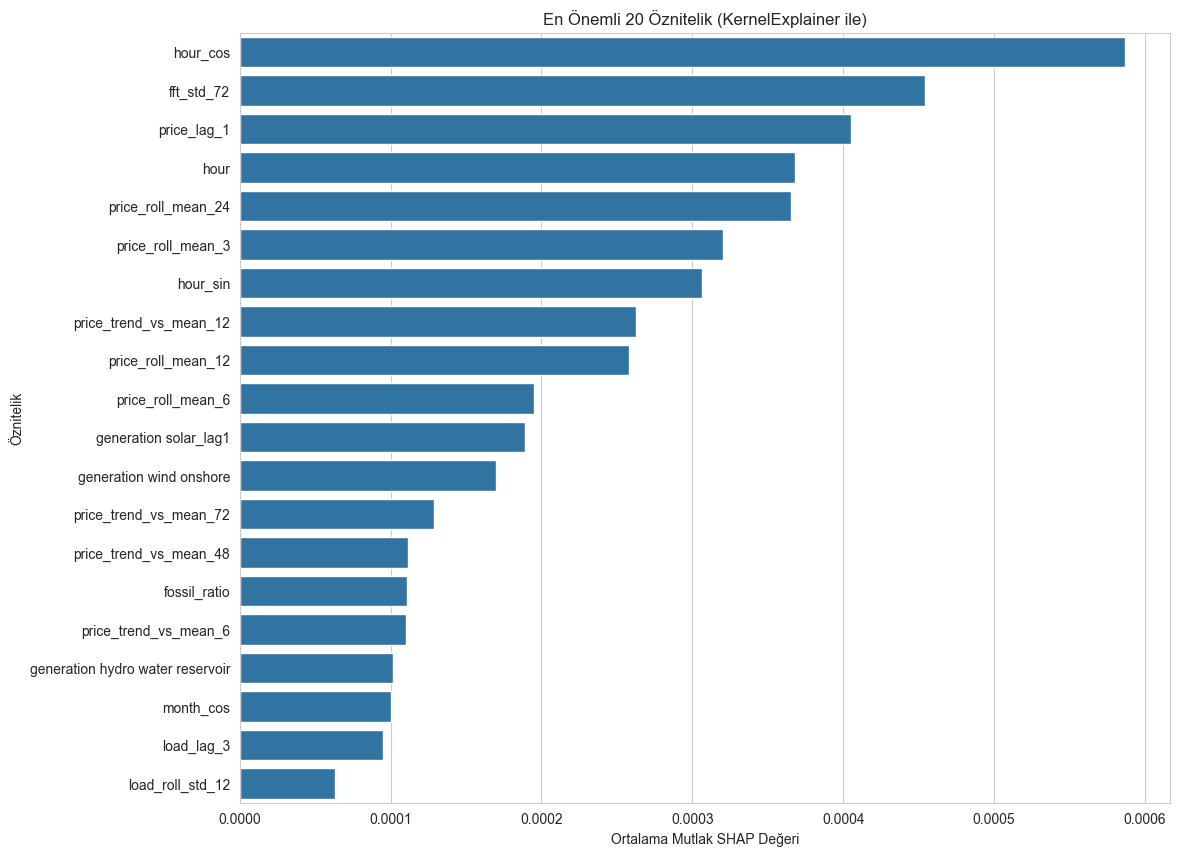


SHAP Özet Grafiği (Özelliklerin Ortalama Değer ve Etkileri):


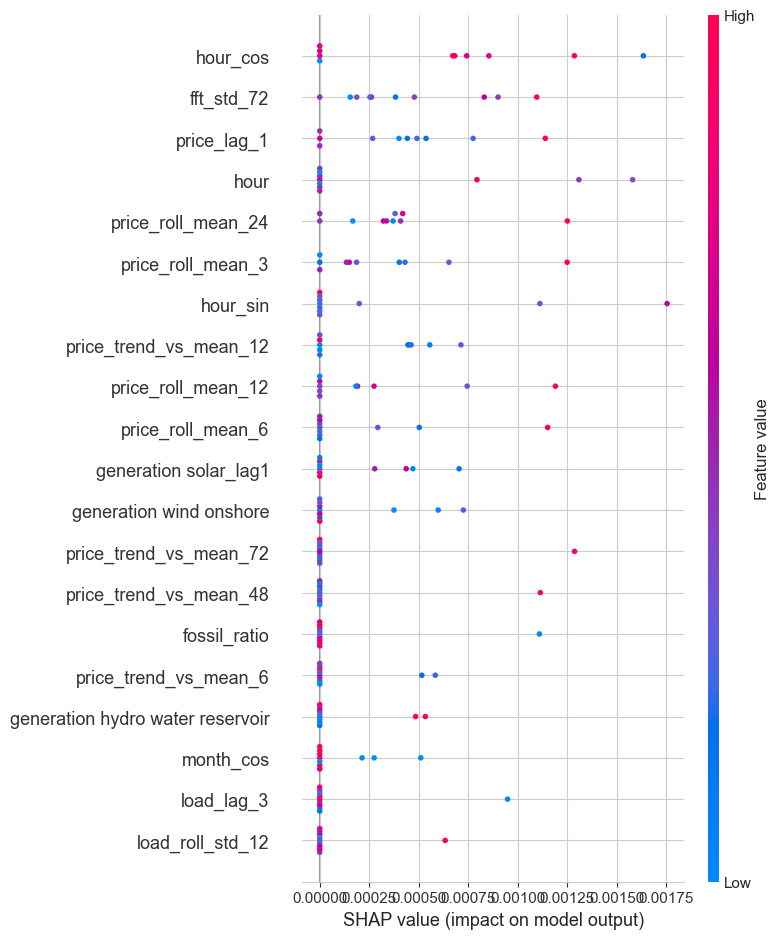

In [ ]:
feature_meta = pd.read_csv(FEATURE_META_PATH)
final_features_1h = feature_meta[feature_meta['used_in_model_1h']]['feature_name'].tolist()

background_data = X_train[np.random.choice(X_train.shape[0], 50, replace=False)]
test_subset = X_test[np.random.choice(X_test.shape[0], 10, replace=False)]

background_data_flat = background_data.reshape(background_data.shape[0], -1)
test_subset_flat = test_subset.reshape(test_subset.shape[0], -1)


print("Arkaplan verisi K-Means ile özetleniyor...")
background_summary = shap.kmeans(background_data_flat, 10) 

def predict_fn(x_flat):
    x_reshaped = x_flat.reshape(-1, X_train.shape[1], X_train.shape[2])
    return best_model.predict(x_reshaped)

explainer = shap.KernelExplainer(predict_fn, background_summary)

print("\nSHAP değerleri hesaplanıyor... Bu işlem ÖNCEKİLERE GÖRE DAHA UZUN SÜREBİLİR.")
# shap_values'ın boyutu şimdi: (10 örnek, 2664 öznitelik_zaman_adımı)
shap_values_flat = explainer.shap_values(test_subset_flat)
print("SHAP değerleri hesaplandı.")



shap_values_3d = shap_values_flat.reshape(test_subset.shape[0], test_subset.shape[1], test_subset.shape[2])

mean_abs_shap = np.abs(shap_values_3d).mean(axis=(0, 1))
feature_importance_df = pd.DataFrame({
    'feature_name': final_features_1h,
    'shap_importance': mean_abs_shap
}).sort_values(by='shap_importance', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x='shap_importance', y='feature_name', data=feature_importance_df.head(20))
plt.title('En Önemli 20 Öznitelik (KernelExplainer ile)')
plt.xlabel('Ortalama Mutlak SHAP Değeri')
plt.ylabel('Öznitelik')
plt.show()

print("\nSHAP Özet Grafiği (Özelliklerin Ortalama Değer ve Etkileri):")
# Analizi basitleştirmek için zaman adımlarının ortalamasını alıyoruz
shap_values_avg_time = shap_values_3d.mean(axis=1)
test_subset_avg_time = pd.DataFrame(test_subset.mean(axis=1), columns=final_features_1h)
shap.summary_plot(shap_values_avg_time, test_subset_avg_time, plot_type="dot")